In [1]:
import prior

dataset = prior.load_dataset("procthor-10k")
dataset

Fetching reference HEAD


[AI2-THOR WARNING] There has been an update to ProcTHOR-10K that must be used with AI2-THOR version 5.0+. To use the new version of ProcTHOR-10K, please update AI2-THOR to version 5.0+ by running:
    pip install --upgrade ai2thor
Alternatively, to downgrade to the old version of ProcTHOR-10K, run:
   prior.load_dataset("procthor-10k", revision="ab3cacd0fc17754d4c080a3fd50b18395fae8647")


Loading test: 100%|██████████| 1000/1000 [00:00<00:00, 6411.25it/s]


DatasetDict(
    train=Dataset(
    dataset=procthor-dataset,
    size=10000,
    split=train
),
    val=Dataset(
    dataset=procthor-dataset,
    size=1000,
    split=val
),
    test=Dataset(
    dataset=procthor-dataset,
    size=1000,
    split=test
)
)

In [2]:
from ai2thor.controller import Controller


house = dataset["train"][3]
controller = Controller(scene=house, snapToGrid=False, rotateStepDegrees=30)
event = controller.step("Pass")
spawn = event.metadata["agent"]["position"]

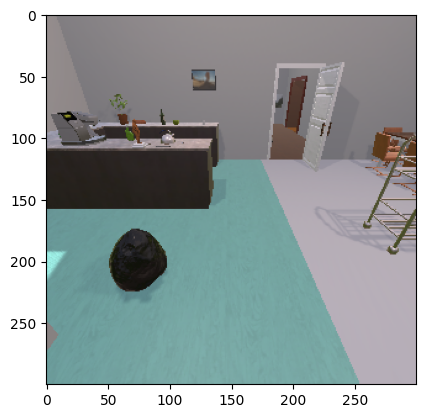

In [3]:
import matplotlib.pyplot as plt
event = controller.step("MoveAhead")
plt.imshow(event.frame)

In [4]:
event.metadata["agent"]["position"]

{'x': 3.5, 'y': 0.9009997844696045, 'z': 5.0}

In [12]:
from rl import PPO, ActorCritic, Env, RolloutBuffer, ClipEnv, CLIPNovelty, load_actor_critic
from models import LSTMActor, LSTMCritic, FrozenResNetEncoder, SlidingWindowTransformerActor, SlidingWindowTransformerCritic
from cons import MINIBATCHES, EPISODE_STEPS, FEAT_DIM, NUM_ACTIONS, DEVICE
import numpy as np

In [6]:
# After loading the scene and stepping once:
event = controller.step("Pass")

# Extract bounding box
bounds_meta = event.metadata.get("sceneBounds", None)
if bounds_meta is None:
    raise KeyError("sceneBounds metadata not found")

center = bounds_meta["center"]
size   = bounds_meta["size"]

xmin = center["x"] - size["x"] / 2
xmax = center["x"] + size["x"] / 2
zmin = center["z"] - size["z"] / 2
zmax = center["z"] + size["z"] / 2

x_center = center["x"]
z_center = center["z"]
house_size = max(size["x"], size["z"]) / 2   # or size["x"]/2 if you want

In [7]:
event = controller.step(
    action="AddThirdPartyCamera",
    position={"x": x_center, "y": 20.0, "z": z_center},
    rotation={"x": 90.0, "y": 0.0, "z": 0.0},
    orthographic=True,
    orthographicSize=house_size,
    fieldOfView=60,
    skyboxColor="black"
)

In [11]:
def get_trajectory(controller, position):
    event = controller.step("Pass")
    # Load the topdown image
    topdown = event.third_party_camera_frames[0]
    H, W = topdown.shape[0], topdown.shape[1]

    # positions is List[(x,z)]
    pos = np.array(position)  # shape (T, 2)
    xs = pos[:,0]
    zs = pos[:,1]

    # Convert meters -> pixels
    img_x = (xs - (x_center - house_size)) * (W / (2 * house_size))
    img_y = (zs - (z_center - house_size)) * (H / (2 * house_size))
    img_y = H - img_y
    return topdown, img_x, img_y

In [11]:
ENTROPY_COEF = 0.05

ppo = PPO(ENTROPY_COEF)
encoder = FrozenResNetEncoder()
actor = SlidingWindowTransformerActor(FEAT_DIM, NUM_ACTIONS)
critic = SlidingWindowTransformerCritic(FEAT_DIM)
clip_novelty = CLIPNovelty()
clip_env = ClipEnv(clip_novelty)
clip_actor_critic = ActorCritic(encoder, actor, critic)


In [12]:
from torchinfo import summary

summary(clip_actor_critic.actor), summary(clip_actor_critic.critic), summary(clip_actor_critic.actor_critic_encoder)

(==========================================================================================
 Layer (type:depth-idx)                                            Param #
 SlidingWindowTransformerActor                                     --
 ├─SinusoidalPositionalEmbedding: 1-1                              --
 ├─TransformerEncoder: 1-2                                         --
 │    └─ModuleList: 2-1                                            --
 │    │    └─TransformerEncoderLayer: 3-1                          789,760
 │    │    └─TransformerEncoderLayer: 3-2                          789,760
 │    │    └─TransformerEncoderLayer: 3-3                          789,760
 │    │    └─TransformerEncoderLayer: 3-4                          789,760
 ├─Linear: 1-3                                                     771
 Total params: 3,159,811
 Trainable params: 3,159,811
 Non-trainable params: 0
 ==========================================================================================,
 Layer (ty

In [ ]:
# load_actor_critic(clip_actor_critic, "data/Full Run/frozen resnet/complete_frozen_89.pt", device=DEVICE)
load_actor_critic(clip_actor_critic, "resnet_18.pt", device=DEVICE)

[🔁] Actor-Critic checkpoint loaded from complete_frozen_89.pt


In [ ]:
from rl import PPO, inference, inference_video_mp4, teleport
import torch
import numpy as np
import matplotlib.pyplot as plt

def get_distributions(ppo: PPO, obs_seq, actions_tensor, clip_actor_critic):
    logits, value = ppo.act_and_value(obs_seq, actions_tensor, clip_actor_critic)
    dist = torch.distributions.Categorical(logits=logits)
    # dist = torch.distributions.Categorical(probs=torch.tensor([0.5,0.25,0.25]))
    return dist


points = {
    "center_point": {'x': 3.25, 'y': 0.9009997844696045, 'z': 5.0},
    "trapped": {'x': 5.6405439376831055, 'y': 0.9009993672370911, 'z': 7.591506481170654},
    "inside_room": {'x': 8.765543937683105, 'y': 0.9009993672370911, 'z': 6.941987037658691},
}

for name, point in points.items():
    position = inference_video_mp4(get_distributions, controller, ppo=PPO(0.08), init_position=point, env=clip_env, actor_critic=clip_actor_critic, video_path=f"rollout{name}.mp4")
    topdown, img_x, img_y = get_trajectory(controller, position)

    plt.figure(figsize=(8,8))
    plt.imshow(topdown)
    plt.plot(img_x, img_y, color="blue", linewidth=2)
    plt.scatter(img_x[0], img_y[0], color="green", label="Start")
    plt.scatter(img_x[-1], img_y[-1], color="blue", label="End")
    plt.legend()
    plt.axis("off")
    plt.savefig(f"rollout{name}.png", bbox_inches='tight', pad_inches=0.1)
    plt.show()

In [8]:
from models import SmallCNNEncoder

ENTROPY_COEF = 0.05

ppo = PPO(ENTROPY_COEF)
encoder = SmallCNNEncoder(FEAT_DIM, device=DEVICE)
actor = SlidingWindowTransformerActor(FEAT_DIM, NUM_ACTIONS)
critic = SlidingWindowTransformerCritic(FEAT_DIM)
clip_novelty = CLIPNovelty()
clip_env = ClipEnv(clip_novelty)
clip_actor_critic = ActorCritic(encoder, actor, critic)

In [9]:
load_actor_critic(clip_actor_critic, "cnn.pt", device=DEVICE)

[🔁] Actor-Critic checkpoint loaded from cnn.pt


In [ ]:
from rl import PPO, inference, inference_video_mp4, teleport
import torch
import numpy as np

def get_distributions(ppo: PPO, obs_seq, actions_tensor, clip_actor_critic):
    logits, value = ppo.act_and_value(obs_seq, actions_tensor, clip_actor_critic)
    dist = torch.distributions.Categorical(logits=logits)
    # dist = torch.distributions.Categorical(probs=torch.tensor([0.5,0.25,0.25]))
    return dist


points = {
    "center_point": {'x': 3.25, 'y': 0.9009997844696045, 'z': 5.0},
    "trapped": {'x': 5.6405439376831055, 'y': 0.9009993672370911, 'z': 7.591506481170654},
    "inside_room": {'x': 8.765543937683105, 'y': 0.9009993672370911, 'z': 6.941987037658691},
}

for name, point in points.items():
    position = inference_video_mp4(get_distributions, controller, ppo=PPO(0.08), init_position=point, env=clip_env, actor_critic=clip_actor_critic, video_path=f"rollout{name}.mp4")
    topdown, img_x, img_y = get_trajectory(controller, position)

    plt.figure(figsize=(8,8))
    plt.imshow(topdown)
    plt.plot(img_x, img_y, color="blue", linewidth=2)
    plt.scatter(img_x[0], img_y[0], color="green", label="Start")
    plt.scatter(img_x[-1], img_y[-1], color="blue", label="End")
    plt.legend()
    plt.axis("off")
    plt.savefig(f"rollout{name}.png", bbox_inches='tight', pad_inches=0.1)
    plt.show()

In [11]:
controller.stop()